# Name: Yichen Huang
# CUID: yh3550

In [15]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# Layer Norm by hand
- Fill in the Layer Norm application below. Make sure the manual and PyTorch implementations are the same.
- As before, FILL_IN the missing code to make this work.

In [16]:
FILL_IN = "FILL_IN"

In [17]:
# This is (N, T, d_model)
# N: batch size
# T: sentence_length
# d_model: embedding dimension

N, T, d_model = 2, 3, 4

# An embedding. This is what you might feed into a network.
embedding = torch.randn(N, T, d_model)

# Create a Layer Norm layer on the embedding dimension.
# Do not include gamma and beta, the learnable scaling and offset parameters.
# This should act of the dimenson of the model.
layer_norm = nn.LayerNorm(d_model)
# Run embedding through the layer_norm layer.
layer_norm_pytorch = layer_norm(embedding)

# Manual computation; use the same EPSILON as is used in the standard nn.LayerNorm.
EPSILON = 1e-05

# Grab the mean of each vector in the first batch. This should be (3, 1).
mean = torch.mean(embedding[0],dim=1).unsqueeze(1)
# Grab the var of each vector in the first batch. This should be (3, 1).
var = torch.var(embedding[0],dim=1,unbiased=False).unsqueeze(1)
# Manually take each vector in the batch and standerdize it.
layer_norm_manual = (embedding[0] - mean) / torch.sqrt(var + EPSILON)
print("layer_norm_manual @ 0: ", layer_norm_manual)
print("layer_norm_out[0]: ", layer_norm_pytorch[0])
assert torch.allclose(layer_norm_pytorch[0], layer_norm_manual), 'Tensors do not match.'

mean = torch.mean(embedding[1],dim=1).unsqueeze(1)
var = torch.var(embedding[1],dim=1,unbiased=False).unsqueeze(1)
layer_norm_manual = (embedding[1] - mean) / torch.sqrt(var + EPSILON)
print("layer_norm_manual @ 1: ", layer_norm_manual)
print("layer_norm_out[1]: ", layer_norm_pytorch[1])
assert torch.allclose(layer_norm_pytorch[1], layer_norm_manual), 'Tensors do not match.'

layer_norm_manual @ 0:  tensor([[ 0.7499, -1.1125,  1.2143, -0.8517],
        [ 0.1187, -1.6203,  1.0921,  0.4095],
        [-1.1663,  1.1724,  0.7924, -0.7984]])
layer_norm_out[0]:  tensor([[ 0.7499, -1.1125,  1.2143, -0.8517],
        [ 0.1187, -1.6203,  1.0921,  0.4095],
        [-1.1663,  1.1724,  0.7924, -0.7984]], grad_fn=<SelectBackward0>)
layer_norm_manual @ 1:  tensor([[ 0.2798,  1.3995, -0.3138, -1.3655],
        [-0.1390,  1.4348,  0.0878, -1.3836],
        [-0.1441, -1.4669,  0.2911,  1.3199]])
layer_norm_out[1]:  tensor([[ 0.2798,  1.3995, -0.3139, -1.3655],
        [-0.1390,  1.4348,  0.0878, -1.3836],
        [-0.1441, -1.4669,  0.2911,  1.3199]], grad_fn=<SelectBackward0>)


### Wave Net

In [18]:
# Hyperparameters we will use.                                                                                                                                                          
batch_size = 128 # How many independent sequences will we process in parallel?                                                                                              
context_size = 256 # What is the maximum context length for predictions? This is T below.                                                                                                    
epochs = 20000
eval_interval = 500
# Is this a good one? Can you check?
learning_rate = 3e-4
device = 'cpu' # Do this if you have a MAC: 'mps' if torch.backends.mps.is_available() else 'cpu'
eval_iters = 200
d_model = 20
d_hidden = 100
n_layer = 1
dropout = 0.2
write_to_file = False
norm = 'batch_norm'

# Add more pritning to the model.
debug = False
# ------------        

In [19]:
torch.manual_seed(1337)

# Load the Shakespere document input.txt.                                                                          
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [20]:
# Get all the unique characters in the text.                                                                                                             
chars = sorted(list(set(text)))
vocab_size = len(chars)
# As usual, create a mapping from a character to a text.                                                                                                                            
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}
# encode: is a lambda function that takes a string and returns  a list of ints, where each character is mapped to the right int.
encode = lambda x: [stoi[c] for c in x]
# decode: is the reverse mapping of encode. It takes a list of int, and returns a string.
decode = lambda x: ''.join([itos[c] for c in x]) 

In [21]:
# Do a train-test split with 90% of the data train and 10% test.
# You can just use the first 90% of the data as training data.
# Run the text through the encode method.
data = encode(text)
n = int(0.9*len(data)) # first 90% will be train, rest val                                                                                                                 
train_data = data[:n]
val_data = data[n:]


In [22]:
# Load the data.
# This should return a small batch of data (x, y) where x is 
def get_batch(split):
    # Generate a small batch of data of inputs x and targets y.
    # Pick the train data if split == 'train', else the validation data.
    data = train_data if split == 'train' else val_data
    # Select a random set of ints [0, len(data) - context_size) ; reshape this to be (batch_size, )
    # For an index i, a x should be data[i:i+context_size] while a y should be data[i+context_size].
    # ix has length batch_size.
    ix = torch.randint(0, len(data) - context_size, (batch_size,))
    # Stack the batch_size data to be of shape (batch_size, context_size)
    x = torch.tensor([data[i.item():i.item()+context_size] for i in ix])
    # Stack the y targets; this should be of length batch_size.
    # You should pull out the i+context_size element of data; i is an index in ix.
    y = torch.tensor([data[i.item()+context_size] for i in ix])                                                                                      
    x, y = x.to(device), y.to(device)
    return x, y

In [23]:
# Estimate the loss.
@torch.no_grad()
def estimate_loss():
    out = {}
    # Put the model in eval mode. Why?
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            xb, yb = get_batch(split)
            logits, loss = model(xb, yb)
            # Get the value in the loss.
            losses[k] = loss.item()
        # Get the mean of the values in the losses.
        out[split] = losses.mean()
    # Put the model in train mode.
    model.train()
    return out

In [24]:
class WaveNetMLPLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
        self.token_embedding_table = nn.Embedding(vocab_size, d_model)
        
        self.linear_layers = []
        self.norm_layers = []
        
        temp_context_size = context_size
        
        while temp_context_size >= 10:
            # Map from 2 * d_model to d_hidden.
            if not self.linear_layers:
                # Add to linear_layers a layer going 2 * d_model to d_hidden.
                self.linear_layers.append(nn.Linear(2 * d_model, d_hidden, bias=False))
            else:
                # Map from 2 * d_hidden to d_hidden.
                # Add to linear_layers a layer going 2 * d_hidden to d_hidden.
                self.linear_layers.append(nn.Linear(2 * d_hidden, d_hidden, bias=False))
            # Append to norm_layers a batch norm 1d with vectors of size d_hidden.
            self.norm_layers.append(nn.BatchNorm1d(d_hidden))
            
            temp_context_size //= 2
        
        # Add a final batch norm 1d with vectors of size vocab_size. 
        self.norm_f = nn.BatchNorm1d(vocab_size) # Final layer norm.
        # Add a Linear layer going from temp_context_size * d_hidden to vocab_size.
        self.ff = nn.Linear(temp_context_size * d_hidden, vocab_size,bias=False)
        
    def forward(self, idx, targets=None):
        N, T = idx.shape

        # idx and targets are both (N, T) tensor of integers                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
        x = self.token_embedding_table(idx) # (N, T, d_model)
        
        for i, _ in enumerate(self.linear_layers):
            N, T, D = x.shape
            # Reshape x to be (N, ??). You want to shrink the context window down by two each time.
            x = x.reshape(N, T // 2, 2 * D)
            # Pass through linear layer i.
            x = self.linear_layers[i](x)
            # Transpose appropriate dimensions of x. Look at the expected dimensions of BatchNorm1d.
            x_res = x.clone()
            x = x.transpose(1, 2)
            # Pass through the batch norm layer.
            x = self.norm_layers[i](x)
            # Transpose back to the previous dimensions.
            x = x.transpose(1, 2)
            # Highway connection.
            # Pass through ReLU.
            x = nn.functional.relu(x) + x_res
        
        # Reshape.
        x = torch.flatten(x, start_dim=1)
        # (N, [T // (2 ** len(self.linear_layers))] * d_model)
        # Apply dropout.
        x = nn.Dropout(p=dropout)(x)
        # Apply self.ff.
        x = self.ff(x) # (N, vocab_size)
        
        x_res = x.clone()
        
        # Apply batch norm.
        x = self.norm_f(x)

        # Apply Tanh.
        logits = x
        #logits = torch.tanh(x) + x_res

        if targets is None:
            loss = None
        else:
            _, T = logits.shape

            assert(T == vocab_size)

            # Apply cross entropy.
            loss = nn.functional.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is a (N, T) array of indices in the current context.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
        for _ in range(max_new_tokens):
            # Here, we crop idx to the last context_size tokens.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
            idx_cond = idx[:, -context_size:] # (N, context_size)
            # Get the predictions; this is just the last timestep.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
            logits, loss = self.forward(idx_cond)
            # Apply softmax to get probabilities.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
            probs = nn.functional.softmax(logits, dim=1) # (N, vocab_size)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
            # Sample from the distribution to get the next character's index.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
            idx_next = torch.multinomial(probs, 1) # (N, 1)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
            # Append sampled index to the running sequence.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
            idx = torch.cat([idx, idx_next], dim=1) # (N, T+1)
            
        return idx # At most, this is (N, T + max_new_tokens) in the second dimension.

Train the model.

In [25]:
model = WaveNetMLPLanguageModel().to(device)
# Print the number of parameters in the model.
print(sum(p.numel() for p in model.parameters())/1000000, 'M parameters')

# Create a PyTorch optimizer. Use AdamW.                                                                                                                                                                                                                                        
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

0.022194 M parameters


In [26]:
zero_grad = []
zero_grad_res = []

In [27]:
train_loss = []
val_loss = []

In [28]:
# Here we loop over max_iters and at each iter we get a batch of data we optimize over.
model.train()
for epoch in range(epochs):

    # every once in a while evaluate the loss on train and val sets                                                                                                                                                                                                 
    if epoch % eval_interval == 0 or epoch == epochs - 1: 
        losses = estimate_loss()
        train_loss.append(losses['train'])
        val_loss.append(losses['val'])
        print(f"step {epoch}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        
    # Sample a batch of data                                                                                                                                                                                                                                        
    xb, yb = get_batch('train')

    # evaluate the loss                                                                                                                                                                                                                                             
    logits, loss = model(xb, yb)
    # Zero the grads.
    optimizer.zero_grad()
    # Get gradients by backprop; do a parameter update.
    loss.backward()
    # count the number of zero gradients
                
    optimizer.step()

step 0: train loss 3.6408, val loss 3.6552
step 500: train loss 3.3328, val loss 3.3691
step 1000: train loss 3.1001, val loss 3.1427
step 1500: train loss 2.9694, val loss 3.0330
step 2000: train loss 2.8897, val loss 2.9709
step 2500: train loss 2.8259, val loss 2.9189
step 3000: train loss 2.7904, val loss 2.8857
step 3500: train loss 2.7483, val loss 2.8596
step 4000: train loss 2.7117, val loss 2.8206
step 4500: train loss 2.6931, val loss 2.8109
step 5000: train loss 2.6687, val loss 2.7979
step 5500: train loss 2.6508, val loss 2.7869
step 6000: train loss 2.6479, val loss 2.7658
step 6500: train loss 2.6228, val loss 2.7605
step 7000: train loss 2.6136, val loss 2.7451
step 7500: train loss 2.6082, val loss 2.7415
step 8000: train loss 2.5941, val loss 2.7417
step 8500: train loss 2.5832, val loss 2.7344
step 9000: train loss 2.5704, val loss 2.7115
step 9500: train loss 2.5717, val loss 2.7123
step 10000: train loss 2.5581, val loss 2.7097
step 10500: train loss 2.5558, val lo

# Plot for input.txt

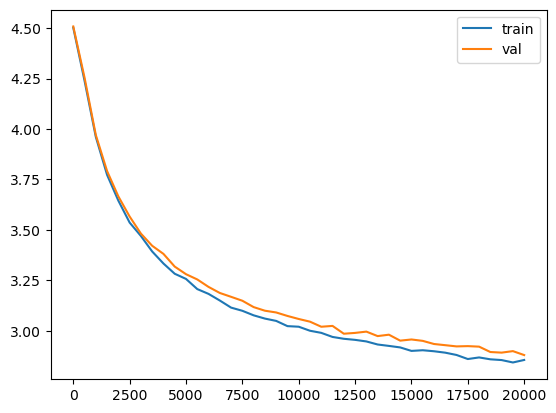

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(0,20500,500),train_loss, label='train')
plt.plot(range(0,20500,500),val_loss, label='val')
plt.legend()
plt.show()

In [ ]:
# Generate from the model and save it to wave_net.txt.
# We generate a maximum of 1000 tokens. 
# We feed in a batch of dimenson (1, context_size).
# The loss should get to ~ 2.0 on train and validation.
# Unfortunately, this will likely not make much sense, the capacity of this model is not ideal for this task.
# The name generation task fro HW 1 might be aother data set to use.
model.eval()
context = torch.tensor(train_data[:256]).reshape(1, 256)
print(decode(model.generate(context, max_new_tokens=500)[0].tolist()))
if write_to_file:
    open('wave_net.txt', 'w').write(decode(model.generate(context, max_new_tokens=10000)[0].tolist()))

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
IeRt
 wehe newoaww.m;
NBIFUmirafsobnsob
T,r,eorf aois!

rywhio gs 'ngeuIm eoo foeTefEkoarsu ue gcre ort domsderdsry thos

t lo frafettteshsndd hgel eoerWeykWsD,
 omsTlncahamo Te ldolu
Ya ssdehn n  fpe lamahor th;ocedyea; Tness tar tassehs hoea e s,? bwair
 s trMnUsy todttYsrs
 aucw bu s oon,
;
 s crI BasItYr Do: ih rehseaco hc dee.

D IqXah  he ,tgllpeaw; lidr suer n yhwh,

t
CGP bate nnessIdpmh vea IlTd Ln  ce  asns time sa eofd, ledm ghu ee s sot? e eomrnL at hnt caLh
a l, c rfhol ictil. ns mo


# plot for name.txt

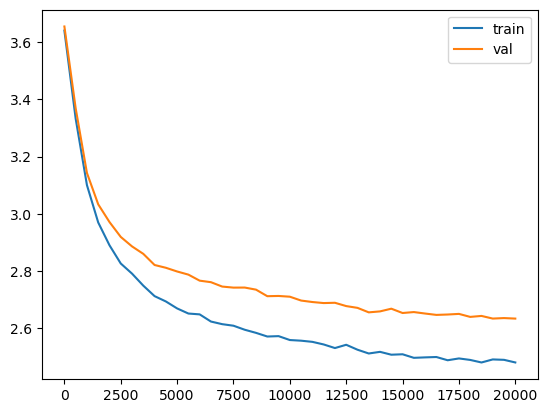

In [29]:
import matplotlib.pyplot as plt

plt.plot(range(0,20500,500),train_loss, label='train')
plt.plot(range(0,20500,500),val_loss, label='val')
plt.legend()
plt.show()

Bonus (+5 max - If you do this and it's all right this assignment will be 13/10.)
- Add some residual connections. Does this improve gradient zero issues?
 - Add some logging to figure out the number of zero gradients across the network before and after you add the residual connections.
- Add some plots that show the train and validation loss, per k iterations. You might want k < 500.
- Use LayerNorm instead of batch norm.
- Use the names.txt file from assignment 1. How do the names look?

In [30]:
model.eval()
context = torch.tensor(train_data[:256]).reshape(1, 256)
print(decode(model.generate(context, max_new_tokens=500)[0].tolist()))
if write_to_file:
    open('name_wave_net.txt', 'w').write(decode(model.generate(context, max_new_tokens=10000)[0].tolist()))

emma
olivia
ava
isabella
sophia
charlotte
mia
amelia
harper
evelyn
abigail
emily
elizabeth
mila
ella
avery
sofia
camila
aria
scarlett
victoria
madison
luna
grace
chloe
penelope
layla
riley
zoey
nora
lily
eleanor
hannah
lillian
addison
aubrey
ellie
stella
nulsse
tu
knijhnyn

edhtsielen
iaoeysh
aylorlmhiyieen

aleina
beahaoes
jy
iie
dylaed
bheiaoo
msrnbii
rcyny
rekenn

uieny
kanhrhn
ayaser
e
darmee
sergen
nnabit
b
oeit
bn
aykyoje
ianki
harajabmylias
gelsri
olaaa
pas
lleal
amuamy
bella
s
evonce
ieeoh
nelreeanntdhlannlve
aalsat
aeio
bfasoya
aroaame

lodjeinah
dandte
peleonnlavn
alhdrnygalli
jiiah
gamiaeahmrea
bard
blailehsgal
eaytahlaanenyn
erijs
aaanyhetn
f
iezzo
sarari
eyixisa
licwanah
hci
reyllna
haasla
nahsoh
alilad
paysfollemmlrahetkajhea
are
ra
